# Project 3: RNNs for Sentiment Analysis (with Attention)


------------------------------------------------------
**Olga Bonachera del Pozo** - 100472782

**Daniel Kwapien** - 100472421

**Alejandro Sánchez** - 100472892

------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently.

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.


In [ ]:
!pip install --upgrade spacy

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
from torch import nn
from torch import optim
import torch

# 1. Import and prepare data

In [ ]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]

def code_opinion(l):
    d = 0
    if (l=='negative\n'):
        d = 1
    elif (l=='positive\n'):
        d = 2
    return d

labels = np.array([code_opinion(l) for l in opinions])

df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

In [ ]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]

In [ ]:
lengths = [len(d) for d in norm_docs]

max_l = np.max([lengths[d] for d in idx_train])

garbage_token = nlp('#') # Junk token --> #

# Normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# Test documents

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

# 2. Import previous architecture

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):


        super().__init__()

        self.hidden_dim = hidden_dim

        self.input_size = input_size

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)

        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        #Log Softmax
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Dropout layer
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):

        batch_size = x.size(0)
        seq_length = x.size(1)

        r_out, _ =  self.rnn(x, h0)

        aux = torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])

        output = self.logsoftmax(self.fc1(self.dropout(aux)))

        return output

In [ ]:
class RNN_with_train(RNN):

    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):

        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)

        self.lr = lr # Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.batch_size = batch_size

        self.saved_files = saved_files


    def predict_proba(self,docs,lengths,Y=None):

        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():

            x_input = torch.Tensor([[w.vector for w in d] for d in docs])

            logprobs = self.forward(x_input,[len(d) for d in docs]).detach().numpy()

            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy


    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):


        self.print_every = print_every

        self.epochs=epochs

        # Optimization Loop

        self.num_train = len(docs_train) # Number of training points

        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches

        self.num_val = len(docs_val) # Number of validation points

        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels

        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels


        for e in range(int(self.epochs)):

            self.train() # Activate dropout

            # Random data permutation

            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings

                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data

                out = self.forward(x_input,[len_train[d] for d in idx_batch])

                # Cost function and gradient descent step

                loss = self.criterion(out,labels[idx_batch])

                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps

                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters

            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                idx = np.random.permutation(self.num_val)

                running_loss = 0.

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]

                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)



            if(e % self.print_every == 0):

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

# 3. Implement Attention

In [ ]:
import torch.nn.functional as F

class Attention(nn.Module):

    def __init__(self, hidden_dim, seq_length):

        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.attn = nn.Sequential(nn.Linear(2 * hidden_dim, 2*hidden_dim), nn.Tanh(), nn.Linear(2*hidden_dim, 1))
        self.softmax = nn.Softmax(dim=1)


    def forward(self, r_out, lengths):

        batch_size = r_out.size(0)
        seq_length = r_out.size(1)

        # Get the last hidden state as the query vector
        query_matrix = torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim]) #(batch_size, hidden_dim)
        query = query_matrix.unsqueeze(1).repeat(1, seq_length, 1)

        # Create the masl
        mask = torch.ones(batch_size, seq_length, self.hidden_dim)
        for j, l in enumerate(lengths):
          mask[j, l:, :] = 0

        # Assign keys
        keys = r_out

        # Create pairs
        query_key_pair = torch.cat((query, keys), dim=2).reshape(-1, 2 * self.hidden_dim)

        # Pass throguh attention
        attention_weights_unnoramalized = self.attn(query_key_pair).view(batch_size, seq_length)

        attention_weights_unnoramalized = attention_weights_unnoramalized.unsqueeze(2).repeat(1, 1, self.hidden_dim)

        # Apply mask and normalize using softmax
        attention_weights = self.softmax(attention_weights_unnoramalized*mask)

        # Obtain the weighted context
        context = (attention_weights*r_out).sum(dim=1)

        return context

In [ ]:
class RNN_with_att(RNN_with_train):
    def __init__(self, input_size, output_size, hidden_dim, seq_length, n_layers, prob=0.3):
      super().__init__(input_size, output_size, hidden_dim, n_layers, prob)
      self.attention = Attention(hidden_dim, seq_length)

    def forward(self, x, lengths, h0=None):
      r_out, _ = self.rnn(x, h0)
      context = self.attention(r_out, lengths)
      output = self.logsoftmax(self.fc1(self.dropout(context)))
      return output

In [ ]:
my_RNN = RNN_with_att(input_size=300,output_size=2,hidden_dim=20, seq_length=max_l, n_layers=1, prob=0.3)

#Call train

my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-17-3dc67421beb8>:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])


Training loss after 0 epochs: 0.4378074448402614. Validation loss: 0.3618886611527867
Training loss after 1 epochs: 0.3645624293856425. Validation loss: 0.3231826134853893
Training loss after 2 epochs: 0.34159225286686257. Validation loss: 0.3047319104274114
Training loss after 3 epochs: 0.3214290195131955. Validation loss: 0.2918609115812514
Training loss after 4 epochs: 0.30908401432919175. Validation loss: 0.28271481146415073
Training loss after 5 epochs: 0.2950425648117719. Validation loss: 0.2718225278788143
Training loss after 6 epochs: 0.2787055538533485. Validation loss: 0.2623496138387256
Training loss after 7 epochs: 0.2656886838886836. Validation loss: 0.2603332855635219
Training loss after 8 epochs: 0.24779300759099934. Validation loss: 0.25610556287897956
Training loss after 9 epochs: 0.23211016883588817. Validation loss: 0.24250383426745734
Training loss after 10 epochs: 0.21910438737640642. Validation loss: 0.2368952048321565
Training loss after 11 epochs: 0.207650270568

Text(0.5, 1.0, 'Training for LSTM with Attention')

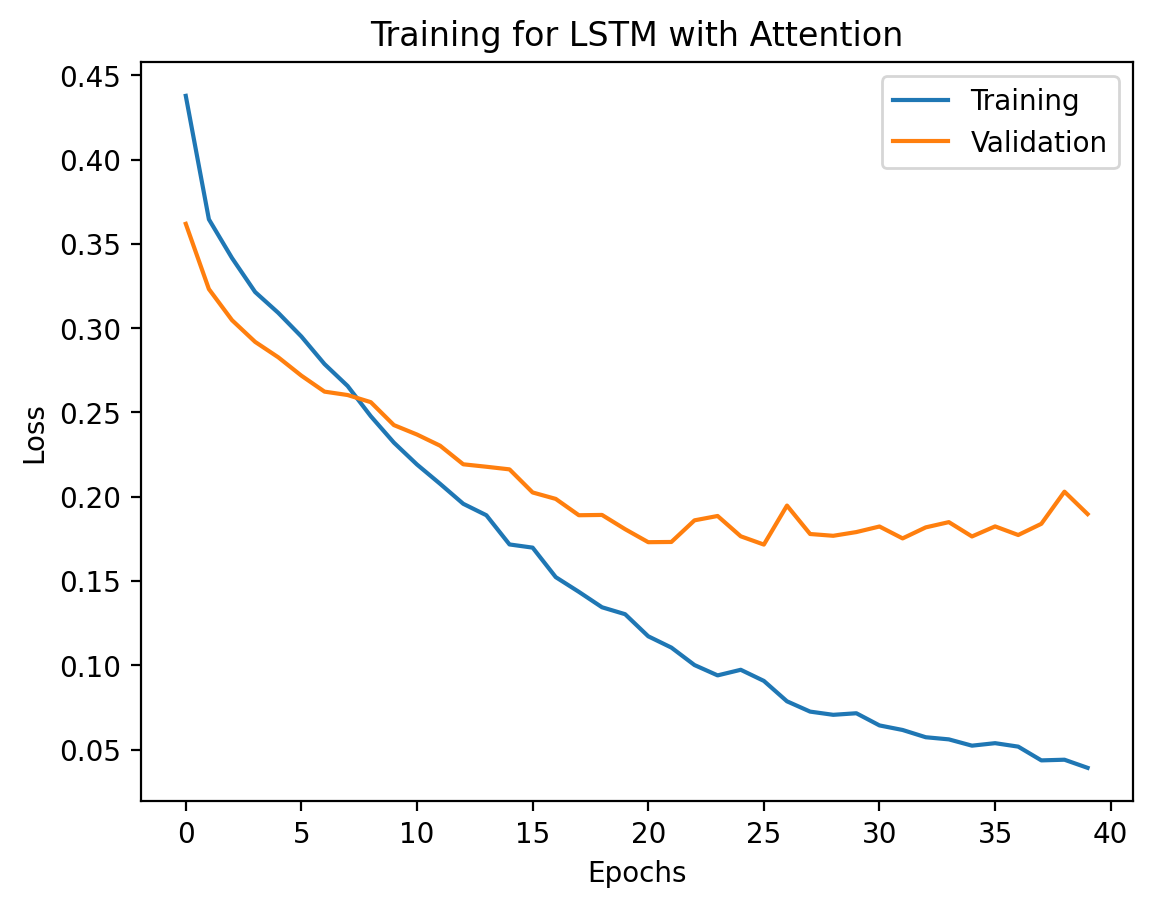

In [ ]:
# Plotting the train/val loss
plt.figure()
plt.plot(my_RNN.loss_during_training, label='Training')
plt.plot(my_RNN.valid_loss_during_training, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training for LSTM with Attention')

In [ ]:
idx_min = np.argsort(my_RNN.valid_loss_during_training)
my_RNN.load_state_dict(torch.load(my_RNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

In [ ]:
logprobs,acc = my_RNN.predict_proba(docs_test, len_test, y_test)

probs = np.exp(logprobs)

print(f"The test accuracy is {acc}")

The test accuracy is 0.9484265734265734


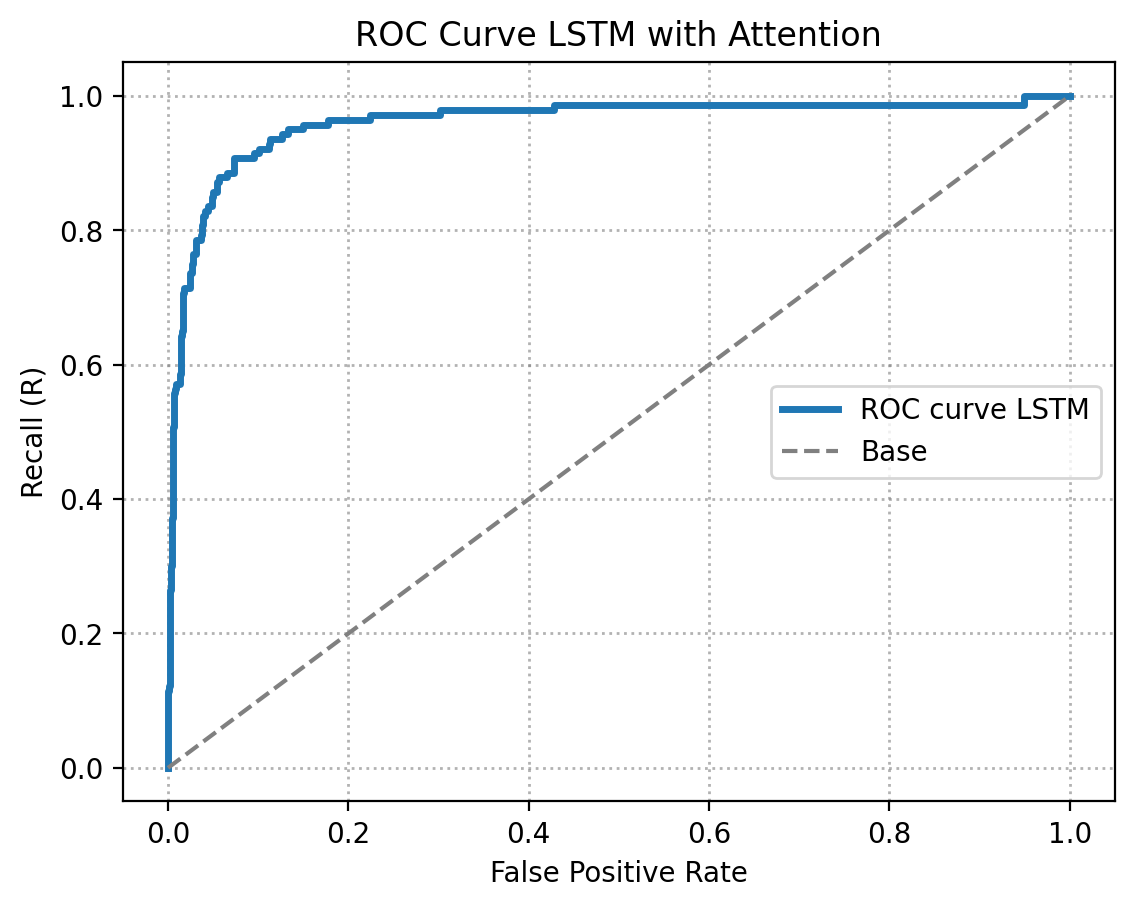

AUC ROC for LSTM with attention is 0.9600811041548094


In [ ]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.5, label='Base')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('ROC Curve LSTM with Attention')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM with attention is {area_roc_LSTM}")

# 4. Conclusions

During this 3rd Project we could study the effects of implementing Attention on a Recurrent Neural Network with LSTM.

### 4.1. Import data

First, we had to import the data used from the `sentences.txt` file, which is a collection of, as it names suggests, raw sentences. Then we transformed it using a pretrained NLP model from spacy, specifically the `en_core_web_md` which is a medium size model, sufficient for our case. Using this model we can obtain the embeddings that we will use as the input for our model

### 4.2. Model without attention

Our model without attention is a Recurrent Neural Network with LSTM (Long Short Term Memory) modules that improve performance. Once an entire sequence is processed we receive the context vector that outputs the last word of the sentence.

Then, we input this context into a simple fully connected layer (preceded by a dropout layer for regularization) and output our result, indicating if the sequence is positve/neutral or negative

<div align="center">
  <img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=500 />
</div>

This plots show the training process of our model:

<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=15prxgvItSGjPdHP1Omjkp4XGHipU3HQ9" width=400/>
</div>

Now, we select the best model using early stopping. Our best model is the one that minimizes validation loss, in this case it corresponds to the model we obtained at epoch 36.

This model has the following performance metrics:
* Training loss: $0.066221$.
*  Validation loss: $0.17350$.
* Test accuracy: $0.88723=88.723\%$
* Area Under the Curve (AUC) of the ROC: $0.85701=85.701\%$

And this is the ROC we obtain:

<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=1tM_7iXFDhfMS1dcDGWFqQIAXzQo_X1pV" width=400/>
</div>


## 4.3. Model with Attention

Now we train the same Recurrent Neural Network with LSTM adding an attention mechanism. This attention mecanism will help the final fully connected layer receive a more broader and better context depending on the sentence we are classifying.

In this case we use a simplified attention mechanism just with queries $q$ and keys $k$, we do not use values.

For this specific case:
* The context of the last word is the query: ${\bf h_{\ell}}={\bf q}.$
* All the contexts we receive from the sentence are the keys: ${\bf h_0},\ldots,{\bf h_\ell} ={\bf H} = {\bf K}.$
* The attention mechanism $a$ is a MLP with 2 layers that receives as input the query ${\bf q}$ and the key ${\bf k_j}$ for $j$-th word in the sentence, our goal is for the MLP to learn the relation betwen the query and key.
* We compute a vector of weights ${\bf w}$ where $w_j = a({\bf q},{\bf k_j})\quad \forall j=1,\ldots,\ell$, where $a$ is the attention.
* Finally we normalize this weights using a softmax function and this the input we use to our final classifier.

Here we can find a sketch of how we implemented this process:

<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=1ekmO81f1DAsItGCOlDQdYC0MjeU3SENH" width=500/>
</div>

Implementing this attention mechanism this is the plot of the training process:

<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=1GKkRd94VsZrBRZaZV9eCDU-w_yZKoV9M" width=400/>
</div>

We select the best model again by early stopping. In this case this the model trained in epoch 30. These are the performance metrics we obtain:
* Training loss: $0.090754$.
* Validation loss: $0.17162$
* Test accuracy: $0.94842=94.842\%$
* Area Under the Curve (AUC) of the ROC: $0.96008=96.008\%$

And this is the ROC curve we obtain:

<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=18pa-phE5Pg02zMRG_yjoH9sHQLhwj68u" width=400/>
</div>

## 4.4. Final comments

As we can see, the performance of the model with attention is a lot better than the model without it, achieving a outstanding accuracy and AUC. By looking at the ROC Curve we can see how it achives a really high AUC, that translates into a really small False Positive Rate.

